In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind

from info import path_to, config
from file_system import FS

def conf_intvl(xs):
    return st.t.interval(0.95, len(xs)-1, loc=np.mean(xs), scale=st.sem(xs))


In [6]:
env = config.default_env_names[0] # 'LunarLanderContinuous-v2' # 'AntBulletEnv-v0', 'LunarLanderContinuous-v2', BipedalWalker-v3, 'HalfCheetahBulletEnv-v0'
resultspath = path_to.folder.results
gamma = 0.98

print(path_to)
# baseline = pd.read_csv(f'{resultspath}/{env}/baseline.csv').rename(columns={'discounted_rewards': 'V'})
afrl = pd.read_csv(
    FS.ensure_parent_folder_exists(path_to.experiment_csv_for(env))
).rename(columns={'discounted_rewards': 'V'})

# base_mean = baseline.V.mean()
# base_low, base_hgh = conf_intvl(baseline.V)

af_means = afrl.groupby('epsilon').V.mean()
af_low, af_hgh = list(zip(*afrl.groupby('epsilon').V.apply(conf_intvl)))

{
    "folder": {
        "agent_models": "data/models/agents", 
        "dynamics_models": "data/models/dynamics", 
        "results": "data/results", 
    }, 
    "file": {"humanoid_agent_model": "log/best_model.zip", }, 
    "agent_model_for": (lambda), 
    "dynamics_model_for": (lambda), 
    "experiment_csv_for": (lambda), 
}


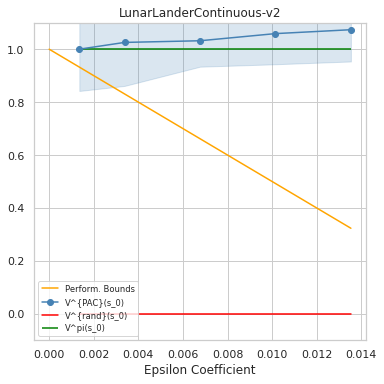

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")


settings = config.train_afrl.env_settings

def mk_plot(env, i):
    # ax = plt.subplot(3,2,i+1)
    ax = plt.subplot(1,1,1)
    afrl = pd.read_csv(path_to.experiment_csv_for(env)).rename(columns={'discounted_rewards': 'V'})
    vmax, vmin = settings[env]['max_score'], settings[env]['min_score']
    vmax = afrl.groupby('epsilon').V.mean().values[0]
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.epsilon / vrange
    base_mean = 1
    af_means = afrl.groupby('eps').opt.mean()
    sd = afrl.groupby('eps').opt.std().values
    epsilon_low, epsilon_hgh = afrl.eps.min(), afrl.eps.max()
    epsilon = np.linspace(0, epsilon_hgh, 2)
    subopt = epsilon / (1 - gamma)
    plt.plot(epsilon, base_mean-subopt, color='orange', label='Perform. Bounds')
    af_means.plot(label='V^{PAC}(s_0)', marker='o', ax=ax, color='steelblue')
    plt.fill_between(af_means.index, af_means-sd, af_means+sd, alpha=0.2, color='steelblue')
    plt.hlines(base_mean, epsilon_low, epsilon_hgh, color='green', label='V^pi(s_0)')

    plt.plot([epsilon_low, epsilon_hgh], [0,0], color='red', label='V^{rand}(s_0)')

    if i == 2:
        plt.ylabel('Performance')
    plt.xlabel('Epsilon Coefficient')

    plt.ylim(-.1, 1.1)

    plt.legend(loc='lower left', fontsize="x-small")


plt.figure(figsize=(5.5, 5.5))
for i, env in enumerate([env]):
    mk_plot(env, i)
    plt.title(env)

plt.tight_layout()

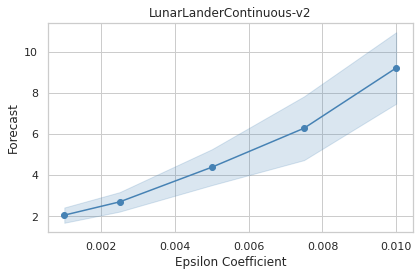

In [8]:
import seaborn as sns
sns.set_theme(style="whitegrid")


def mk_plot(env):
    afrl = pd.read_csv(path_to.experiment_csv_for(env)).rename(columns={'discounted_rewards': 'V', 'Unnamed: 0': 'episode'})
    vmax, vmin = settings[env]['max_score'], settings[env]['min_score']
    vrange = vmax - vmin
    afrl['opt'] = (afrl.V - vmin) / vrange
    afrl['eps'] = afrl.epsilon / vrange

    f_means = afrl.groupby('eps').forecast.mean() + 1
    sd = afrl.groupby(['eps', 'episode']).forecast.mean().unstack().std(1)

    f_low, f_hgh = f_means + sd, f_means - sd
    f_means.plot(marker='o', label='V^F(s_0)', color='steelblue')
    plt.fill_between(f_means.index, np.where(f_low < 0, 0, f_low), f_hgh, alpha=0.2, color='steelblue')

    plt.xlabel('Epsilon Coefficient')

    plt.ylabel('Forecast')    



mk_plot(env)
plt.title(env)
plt.tight_layout()

/home/josiah/miniconda3/envs/afrl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


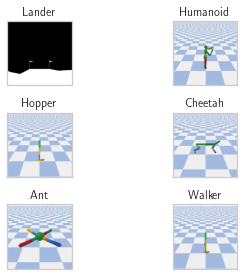

In [26]:
import gym
import pybullet_envs

import sys
# sys.path.insert(0,'/home/josiah/code/afrl/afrl') # QUESTION: is this the repo folder? if so then shouldnt it already be ont he path
from env_meta import envs # not a project file or pip module: error no module found

envs2 = ([gym.make(env['name']) for env in envs.values()])
imgs = []
for env in envs2:
    env.render('rgb_array')
    env.reset()
    # env.step(env.action_space.sample())
    imgs.append(env.render('rgb_array'))
    env.close()
import matplotlib.pyplot as plt

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

for i, img in enumerate(imgs):
    plt.subplot(3, 2, i+1)
    diff = img.shape[1] - img.shape[0]
    trim = diff // 2
    img = img[:,trim:img.shape[1]-trim,:]
    
    plt.imshow(img)
    # plt.frame(off)
    plt.xticks([])
    plt.yticks([])
    plt.title(list(envs.keys())[i])

plt.tight_layout()

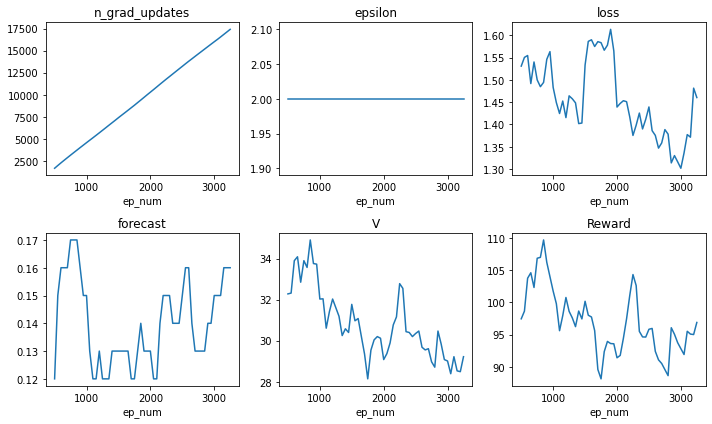

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

df = pd.read_csv('data/results/LunarLanderContinuous-v2/experiments_pp3.csv')
df = df.set_index('ep_num')
for i, col in enumerate(df.columns):
    ax = plt.subplot(2, 3, i+1)
    df[col].iloc[1:].rolling(10).mean().plot(ax=ax)
    plt.title(col)
plt.tight_layout()